# Temperature Profile Classification - 2 Class system
GMM classification of Southern Ocean Argo float temperature profile data. This notebook looks at automatic generation for PCA N values, with 2 classes.<br><br>
### Dask import

<br>

### Choices for data

In [1]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#File imports
maskName = "OceanMaskVolcello"
dataFileName = "GMMSampleDataUK1L.npy"
sampleFileName = "GMMSampleTimeGeoUK1.npy"
scalerName = "GMMScalerUK1L.bin"
modelName = "GMMUK2Class2"

#Data definitions
startDate = '1980-01'
endDate = '2009-12'
timeRange = slice(startDate, endDate)
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
runIdSel = 0

#Custom GMM variables
createModel = True #if true creates a new model in this notepad. if false the model in modelname is imported
saveModel = True #if true saves a model under model name. To work createModel has to be enabled.
pcaThreshold = 0.98
pcaNControl = 3 #set to int value to select, otherwise pcaThreshold is used to automatically assign value
firstBicLoopControl = 10 #number of times bic value is calculated for each number of classes
cvType = "full"

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
import calendar
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import config
from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceId) & df.institution_id.eq(dataInstitutionId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]
dfFilt = dfFilt[:1]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" "+dataSourceId+" data sets opened")
else:
    print("No UKESM data sets opened")
    
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunId') #Combining data sets

dataRaw = fileSet.thetao

try:
    dataRaw = dataRaw.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

print("Data sets successfully merged and renamed into dataRaw.")
dataRaw

1 UKESM1-0-LL data sets opened
Data sets successfully merged and renamed into dataRaw.


<xarray.DataArray 'thetao' (RunId: 1, time: 1980, lev: 75, j: 330, i: 360)>
dask.array<broadcast_to, shape=(1, 1980, 75, 330, 360), dtype=float32, chunksize=(1, 8, 75, 330, 360), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 321 322 323 324 325 326 327 328 329
    lat      (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
    lon      (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
Dimensions without coordinates: RunId

In [4]:
dfESMLev = dataRaw.sel(lev=levSel) #Selects level data down to 2k
dfESMLevT = dfESMLev.sel(time=timeRange)
dfESMLatLevT = dfESMLevT.where(dfESMLevT.lat < maxLat, drop=True) #Selection of latitude
dfESMLatLevT = dfESMLatLevT.squeeze()
#dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("UKESM data loaded and stored in dfESMLatLevT")
dfESMLatLevT #Uncomment to see data set

UKESM data loaded and stored in dfESMLatLevT


<xarray.DataArray 'thetao' (time: 360, lev: 54, j: 139, i: 360)>
dask.array<getitem, shape=(360, 54, 139, 360), dtype=float32, chunksize=(8, 54, 5, 360), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137 138
    lat      (j, i) float32 dask.array<chunksize=(139, 360), meta=np.ndarray>
  * lev      (lev) float64 0.5058 1.556 2.668 ... 1.653e+03 1.796e+03 1.945e+03
    lon      (j, i) float32 dask.array<chunksize=(139, 360), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2009-12-01

<br>
<b>Loading ocean Masks</b>

In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
#maskFile = xr.open_dataset("OceanMaskUKESM1")
#oceanMask2 = maskFile.to_array()
print("Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).")

Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).


<br>
<b>Unpacking ocean masks</b>

In [6]:
geoRange = oceanMask #copying mask
geoRange = geoRange.rename({"variable":"cleanMe"}) #Dimension removal
geoRange = geoRange.sel(cleanMe = geoRange.cleanMe.values[0]) #Dimension removal
geoRange = geoRange.reset_coords("cleanMe", drop=True) #Dimension removal
geoRangeS = geoRange.stack(ij =("i", "j")) #Stacking
geoRangeFilt = geoRangeS.dropna("ij")
print("Ocean mask unpacked into geoRangeFilt.")

#geoRange2 = oceanMask2 #copying mask
#geoRange2S = geoRange2.stack(ij =("i", "j")) #Stacking
#geoRangeFilt2 = geoRange2S.dropna("ij")
print("UKESM Ocean mask unpacked into geoRangeFilt2.")

Ocean mask unpacked into geoRangeFilt.
UKESM Ocean mask unpacked into geoRangeFilt2.


<br>
<b>Date Calculations</b>

In [7]:
startDateNp = np.datetime64(startDate, 'M')
endDateNp = np.datetime64(endDate, 'M')

timeDiff = endDateNp - startDateNp
timeDiff = timeDiff.astype(int) + 1
print("Calculated date range.")

Calculated date range.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
<li>storeMeta - Returns a np array containing the latitude and longitude data for an input xarray and associated ij.
<li>loadModel - loadeds and returns GMM model named in input.
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
</ul>

In [54]:
def pickRand(dataArray, sampleFactor):
    '''Returns a sample of the input array, size of sampled array is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    arrLen = len(dataArray)
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*arrLen)
    else:
        return 1
    
    filtArr = np.zeros(arrLen, dtype=bool) # empty mask
    sampleId = np.random.choice(arrLen, sampleSize, False) # np array of randomly generated non repeating numbers
    for i in sampleId:
        filtArr[i] = True # populating mask
    return dataArray[filtArr] # applies mask

def pickRandMask(maskLen, maskQuantity, sampleFactor):
    '''Returns a linear mask for the input dimensions, size of mask is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*maskLen)
    else:
        return 1
    
    globalArr = np.empty(shape=(0), dtype=bool)
    for i in range(maskQuantity):
        filtArr = np.zeros(maskLen, dtype=bool) # empty mask
        sampleId = np.random.choice(maskLen, sampleSize, False) # np array of randomly generated non repeating numbers
        for j in sampleId:
            filtArr[j] = True # populating mask
        globalArr = np.append(globalArr, filtArr)
    return globalArr


def storeMeta(dataArray):
    '''Returns a np array containing the latitude and longitude data for the input xarray and the associated ij index'''
    storeLen = len(dataArray["lat"]) # assumes each lat has a corresponding lon
    storage = np.empty(shape=(0,storeLen))
    storage = np.append(storage, [dataArray["lat"].values], axis = 0)
    storage = np.append(storage, [dataArray["lon"].values], axis = 0)
    #storage = np.append(storage, [dataArray["time"].values], axis = 0)
    #storage = np.append(storage, [dataArray["ij"].values], axis = 0)
    return storage


def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel


def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> bicPlot - Plots BIC score array against component number.
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDF - plots location and classification of data points for an input data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
<li> tempPointPlot - Plots the temperature profile of a single point against depth.
<li> tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [126]:
sampleDepthAxis = dfESMLatLevT["lev"]

def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    bicArrayMin = np.min(bicArray)
    bicRange = bicArrayMax-bicArrayMin
    if bicRange == 0:
        bicRange = 20 #provides border 1 if all bic values are identical
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([bicArrayMin-0.05*bicRange, bicArrayMax+0.05*bicRange])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)


def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")


def locationPlotGroupDFTime(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  mdates.date2num(dataFrame["time"]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotGroupDFLab(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")


def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotXr(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree())
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray["lat"]))+")")        


def tempPointPlot(dataArray, label, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))
    plt.gca().invert_yaxis()


def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0].values)[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)
        '''


print("Plotting functions defined.")

Plotting functions defined.


<br>

### Plotting Ocean Mask

In [10]:
#locationPlotXr(geoRangeFilt, (10,10), 1)
#locationPlotXr(geoRangeFilt2, (10,10), 2)

### Generating Data Samples

In [131]:
#dfESMLatLevTFilt = dfESMLatLevT.where(~np.isnan(geoRange),drop=True)
dfESMLatLevTFilt = dfESMLatLevT.where(geoRange==1,drop=True) ###########################?
if True:
    dfESMLatLevTFiltStack = dfESMLatLevTFilt.stack(ij=('i','j')) #Produces 32400
    dfESMLatLevTFiltStack = dfESMLatLevTFiltStack.transpose('time', 'ij', 'lev')
dfESMLatLevTFilt
#dfESMLatLevTFiltStack

,Array,Chunk
Bytes,2.35 GiB,2.97 MiB
Shape,"(360, 54, 90, 360)","(8, 54, 5, 360)"
Count,6380 Tasks,855 Chunks
Type,float32,numpy.ndarray


In [29]:
dfESMLatLevTStack = dfESMLatLevT.stack(ij =("i", "j"))
dfESMLatLevTStack = dfESMLatLevTStack.transpose('time', 'ij', 'lev')
dfESMLatLevTStackFilt = dfESMLatLevTStack.sel(ij = geoRangeFilt.ij.values) #Produces 22194
dfESMLatLevTStackFilt

<xarray.DataArray 'thetao' (time: 360, ij: 22194, lev: 54)>
dask.array<getitem, shape=(360, 22194, 54), dtype=float32, chunksize=(8, 1309, 54), chunktype=numpy.ndarray>
Coordinates:
    lat      (ij) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * lev      (lev) float64 0.5058 1.556 2.668 ... 1.653e+03 1.796e+03 1.945e+03
    lon      (ij) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2009-12-01
  * ij       (ij) MultiIndex
  - i        (ij) int64 0 0 0 0 0 0 0 0 0 ... 359 359 359 359 359 359 359 359
  - j        (ij) int64 81 82 83 84 85 86 87 88 ... 132 133 134 135 136 137 138

In [55]:
ijLen = len(dfESMLatLevTStackFilt["ij"])
timeLen = len(dfESMLatLevTStackFilt["time"])
mask = pickRandMask(ijLen, timeLen, 0.34)

print("Data mask calculated")

array([ True, False, False, ...,  True,  True, False])

In [62]:
sampleDataRaw = dfESMLatLevTStackFilt.reset_index('ij')
sampleDataRaw = sampleDataRaw.stack(ijT = ('time', 'ij'))
sampleData = sampleDataRaw[:,mask]
sampleData = sampleData.transpose('ijT', 'lev')
print("Sample data calculated and stored in sampleData.")
sampleData

Sample data calculated and stored in sampleData.


<xarray.DataArray 'thetao' (ijT: 2716200, lev: 54)>
dask.array<transpose, shape=(2716200, 54), dtype=float32, chunksize=(7545, 54), chunktype=numpy.ndarray>
Coordinates:
    lat      (ijT) float32 dask.array<chunksize=(2716200,), meta=np.ndarray>
  * lev      (lev) float64 0.5058 1.556 2.668 ... 1.653e+03 1.796e+03 1.945e+03
    lon      (ijT) float32 dask.array<chunksize=(2716200,), meta=np.ndarray>
    i        (ijT) int64 0 0 0 0 0 0 0 0 0 ... 359 359 359 359 359 359 359 359
    j        (ijT) int64 81 85 92 94 95 96 98 ... 130 131 133 134 135 136 137
  * ijT      (ijT) MultiIndex
  - time     (ijT) datetime64[ns] 1980-01-01 1980-01-01 ... 2009-12-01
  - ij       (ijT) int64 0 4 11 13 14 15 ... 22186 22188 22189 22190 22191 22192

In [61]:
metaData = {"lat":sampleData["lat"], "lon":sampleData["lon"], "time":sampleData["time"]}
sampleMetaDF = pd.DataFrame(metaData, columns=["lat", "lon", "time"])
print("Sample lat, lon and time converted to datafile (sampleMetaDF).")
sampleMetaDF

Sample lat, lon and time converted to datafile (sampleMetaDF).


,lat,lon,time
0,-66.111519,73.5,1980-01-01
1,-64.439102,73.5,1980-01-01
2,-61.247692,73.5,1980-01-01
3,-60.270821,73.5,1980-01-01
4,-59.771149,73.5,1980-01-01
...,...,...,...
2716195,-34.667751,72.5,2009-12-01
2716196,-33.841221,72.5,2009-12-01
2716197,-33.006615,72.5,2009-12-01
2716198,-32.164040,72.5,2009-12-01


In [134]:
exportName = modelName + "_Meta"
#sampleMetaDF.to_csv(exportName) #Exporting meta data
exportName = modelName + "_Mask"
#np.save(exportName, mask)
print("Meta data and mask exported to "+modelName+" _Meta.csv and _Mask.npy respectively")

In [71]:
#x =

#Generating surface temperature level value and column name
surfaceTemp = sampleData["lev"][0].values
surfaceData = sampleData.sel(lev = surfaceTemp)
surfaceTempName = "Surface Temp ("+str(np.round(surfaceTemp,2))+")"

#Exporting sample data into pandas
if True:
    #sampleDataDF = pd.DataFrame(surfaceData.values, columns=[surfaceTempName])
    sampleDataDF = sampleData.to_pandas()
    
    sampleDataDFClean = sampleDataDF.reset_index()
    sampleDataDFClean = sampleDataDFClean.drop(columns=['ij'])
    sampleDF = pd.concat([sampleMetaDF,sampleDataDFClean], axis=1)
else:
    sampleDF = sampleMetaDF
    
sampleDF["time"] = pd.to_datetime(sampleDF["time"])
print("SampleData converted to datafile (sampleDataDF).  Datafiles combined into sampleDF.")
sampleDF

SampleData converted to datafile (sampleDataDF).  Datafiles combined into sampleDF.


,lat,lon,time,0.5057600140571594,1.5558552742004395,2.6676816940307617,3.8562798500061035,5.140361309051514,6.543033599853516,8.09251880645752,...,856.678955078125,947.4478759765625,1045.854248046875,1151.9912109375,1265.8614501953125,1387.376953125,1516.3636474609375,1652.5684814453125,1795.6707763671875,1945.2955322265625
0,-66.111519,73.5,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-64.439102,73.5,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-61.247692,73.5,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-60.270821,73.5,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-59.771149,73.5,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2009-12-01 00:00:00, 22188)",NaN,NaN,NaT,16.907646,16.892517,16.855930,16.817078,16.777569,16.737909,16.697313,...,8.411176,7.029521,5.836586,4.910458,4.262508,3.863432,3.616004,3.402862,3.208943,3.027852
"(2009-12-01 00:00:00, 22189)",NaN,NaN,NaT,17.512085,17.494389,17.459238,17.412260,17.368893,17.328562,17.285444,...,8.353155,6.952757,5.757030,4.835512,4.208164,3.827663,3.580026,3.366771,3.174868,2.988555
"(2009-12-01 00:00:00, 22190)",NaN,NaN,NaT,18.148270,18.131943,18.087517,18.045628,18.008326,17.969124,17.926830,...,8.270664,6.861818,5.667482,4.757580,4.155083,3.791105,3.543930,3.331373,3.139950,2.948072
"(2009-12-01 00:00:00, 22191)",NaN,NaN,NaT,18.893051,18.864576,18.813694,18.771439,18.731888,18.690823,18.646151,...,8.171999,6.762429,5.572254,4.680170,4.104445,3.754675,3.508667,3.296652,3.104402,2.907982


In [103]:
#sampleDataDFClean = sampleDataDF.reset_index()
#sampleDataDFClean = sampleDataDFClean.drop(columns=['ij'])
sampleDF = pd.concat([sampleMetaDF, sampleDataDFClean], axis=1)
sampleDF

,lat,lon,time,time,0.5057600140571594,1.5558552742004395,2.6676816940307617,3.8562798500061035,5.140361309051514,6.543033599853516,...,856.678955078125,947.4478759765625,1045.854248046875,1151.9912109375,1265.8614501953125,1387.376953125,1516.3636474609375,1652.5684814453125,1795.6707763671875,1945.2955322265625
0,-66.111519,73.5,1980-01-01,1980-01-01,-1.584012,-1.583307,-1.586312,-1.589255,-1.592438,-1.596716,...,0.326054,0.293914,0.235124,0.175954,0.151899,0.117106,0.100809,0.081946,0.069353,0.049921
1,-64.439102,73.5,1980-01-01,1980-01-01,-1.574742,-1.585120,-1.596939,-1.606296,-1.614212,-1.620101,...,0.455728,0.410390,0.363946,0.316337,0.268540,0.221310,0.178075,0.140615,0.109725,0.084378
2,-61.247692,73.5,1980-01-01,1980-01-01,-1.113895,-1.117073,-1.121178,-1.126438,-1.132662,-1.139567,...,1.478742,1.373295,1.262428,1.147904,1.030973,0.912692,0.793082,0.672521,0.554682,0.444082
3,-60.270821,73.5,1980-01-01,1980-01-01,-1.064825,-1.071327,-1.076603,-1.082442,-1.089007,-1.096493,...,1.414679,1.315174,1.208778,1.096937,0.980770,0.862251,0.743711,0.630702,0.527892,0.445035
4,-59.771149,73.5,1980-01-01,1980-01-01,-0.885555,-0.895390,-0.903586,-0.914104,-0.925726,-0.939169,...,1.329765,1.237344,1.138445,1.034469,0.925340,0.811147,0.697708,0.596718,0.506726,0.454387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716195,-34.667751,72.5,2009-12-01,2009-12-01,16.907646,16.892517,16.855930,16.817078,16.777569,16.737909,...,8.411176,7.029521,5.836586,4.910458,4.262508,3.863432,3.616004,3.402862,3.208943,3.027852
2716196,-33.841221,72.5,2009-12-01,2009-12-01,17.512085,17.494389,17.459238,17.412260,17.368893,17.328562,...,8.353155,6.952757,5.757030,4.835512,4.208164,3.827663,3.580026,3.366771,3.174868,2.988555
2716197,-33.006615,72.5,2009-12-01,2009-12-01,18.148270,18.131943,18.087517,18.045628,18.008326,17.969124,...,8.270664,6.861818,5.667482,4.757580,4.155083,3.791105,3.543930,3.331373,3.139950,2.948072
2716198,-32.164040,72.5,2009-12-01,2009-12-01,18.893051,18.864576,18.813694,18.771439,18.731888,18.690823,...,8.171999,6.762429,5.572254,4.680170,4.104445,3.754675,3.508667,3.296652,3.104402,2.907982


In [ ]:
#exportName = modelName + "DataXr"
#sampleDataExport = sampleData.reset_index('ijT')
#sampleDataExport.to_netcdf(exportName)
#sampleDataReload = xr.open_dataset(exportName)
#sampleDataReload

In [ ]:
#locationPlotGroupDFTime(sampleDF, "Sample locations", (10,10), 1)

### Scaling
<b>Scaling Implementation</b><br>
Applying scaling to the data set, ensuring all levels have same influence over data.

In [67]:
scalerLoad = load(scalerName)
sampleDataScaled = scalerLoad.transform(sampleData)
print("Scaling of sampleData complete, stored in sampleDataScaled.")

c:\users\ellaw\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Scaling of sampleData complete, stored in sampleDataScaled.


<br>
<b>Scaling comparison</b><br>
Comparing raw temperature profiles with their scaled equivalent. To show individual plots set solo to True.

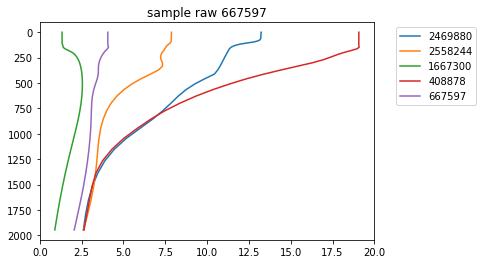

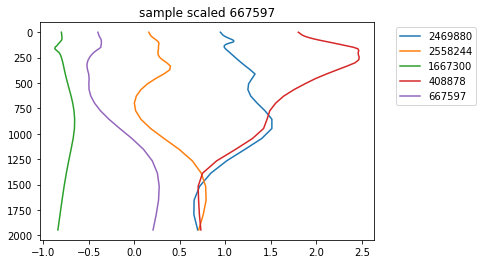

In [68]:
solo = False #Set to true for seperate plots, false for combined plots.
for i in range(5):
    x = np.random.randint(len(sampleMetaDF))
    tempPointPlot(sampleData[x], x, "sample raw "+str(x), solo*2*i)
    tempPointPlot(sampleDataScaled[x], x, "sample scaled "+str(x), solo*2*i+1)

<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [70]:
pca = PCA(n_components=pcaNControl) #initialising PCA 
pca.fit(sampleDataScaled) #fitting model to data
sampleDataScaledPCA = pca.transform(sampleDataScaled) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### Model generation/BIC score calculation
To identify the best fitting models a BIC score metric is used, with a lower BIC score indicating a better model. BIC scores for each number of classes will differ based on starting values used in the modelling, so repeated runs of the BIC scoring helps to provide a more overall score for each number of classes.

The number of iterations for each quantity of classes can be controlled by modifying the bicLoopControl variable at the top of the notepad in [Choices for data](#Choices-for-data).

In [104]:
if createModel:
    bicMin = np.infty
    bicComponentMin = 2
    bicRaw = np.empty(shape=(0))

    bicCurrentArray = np.empty(shape=(0))
    for i in range(firstBicLoopControl):    #Number of iterations for each number of components
        GMModel = mixture.GaussianMixture(n_components = 2, covariance_type = cvType) #Run modelling
        GMModel.fit(sampleDataScaledPCA)

        bicCurrent = GMModel.bic(sampleDataScaledPCA)
        bicCurrentArray = np.append(bicCurrentArray, bicCurrent)
        if bicCurrent < bicMin:   #if latest BIC score is lowest, update and save model
            bicMin = bicCurrent
            bicComponentMin = 2
            bestGMModel = GMModel
            GMMRunId = i

    bicRaw = np.append(bicRaw, bicCurrentArray)  
    componentNo = bestGMModel.n_components

    if componentNo != bicComponentMin:
        print("Warning, error with assigning optimum GMM. The model was unable to be saved.")
    elif saveModel:
        saveModel(bestGMModel, modelName)
        print("Best GMM from training saved to "+modelName+".")
        
    print("Modelling and scoring complete. The lowest bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+" from run "+str(GMMRunId)+".")
    print("BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.")
else:
    bestGMModel = loadModel(modelName)
    bicMin = bestGMModel.bic(sampleDataScaledPCA)
    bicComponentMin = bestGMModel.n_components
    print("Model "+modelName+" loaded. The bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+".")

Best GMM from training saved to GMMUK2Class2.
Modelling and scoring complete. The lowest bicScore was 29629318.16 for 2 from run 7.
BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.


<br>

### BIC score calculations
The average and minimum BIC scores for each number of components are calculated and stored in the corresponding arrays.

In [105]:
if createModel:
    bicAvg = np.infty
    bicAvg = np.mean(bicRaw)
    print("BIC score sorting finished. Lowest scores for each component value stored in bicMin, with average BIC scores stored in bicAvg.")
else:
    print("Imported model "+modelName+" in use. No calculations necessary.")

BIC score sorting finished. Lowest scores for each component value stored in bicMin, with average BIC scores stored in bicAvg.


<br>

### BIC score plotting
Plotting the BIC scores from the modelling. The minimum BIC score indicates the ideal number of classes to be used in the model.

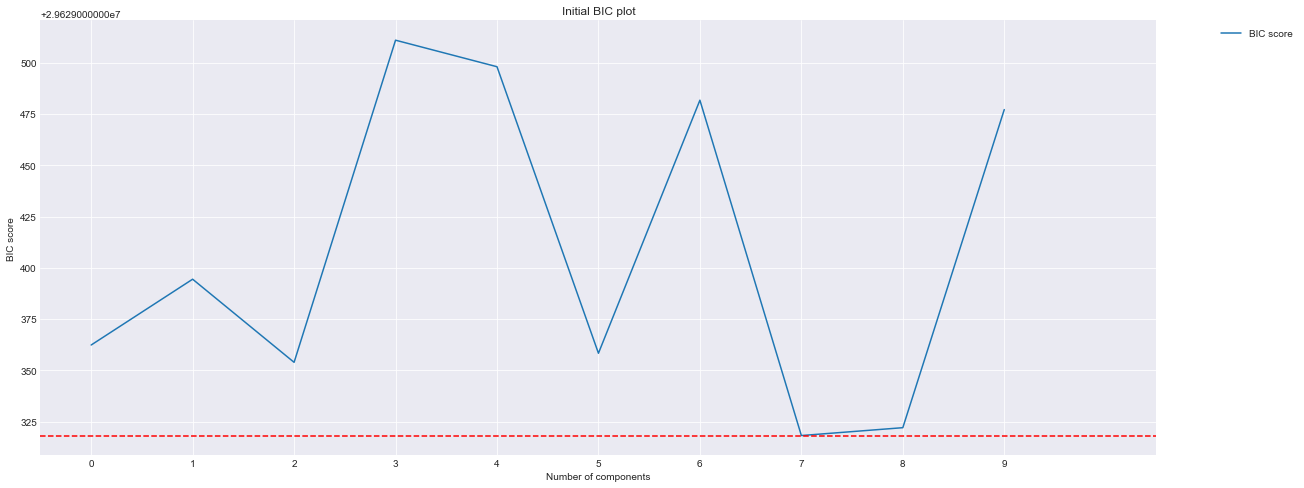

Component number with minimum BIC score: 2 with a score of 29629318.161509678 from run 7.


In [106]:
if createModel:
    bicPlot(bicRaw, 0, firstBicLoopControl, 1, "Initial BIC plot", "BIC score", 1)
    plt.axhline(bicMin, color = "Red", ls="--")

    plt.show()
    print("Component number with minimum BIC score: "+str(componentNo)+" with a score of "+str(bicMin)+" from run "+str(GMMRunId)+".")
else:
    print("Imported model "+modelName+" in use. Model BIC score for training data: "+str(bicMin)+".")

<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [107]:
labels = bestGMModel.predict(sampleDataScaledPCA) #assignment of class labels from best GMM

posteriorProbs = bestGMModel.predict_proba(sampleDataScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs

try:
    sampleDF = sampleDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
sampleDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

Labels identified for model (2 components) and added to sampleDF with associated probability.


<br>

### Calculating properties of profiles based on class assignment

Investigate

In [108]:
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).


<br>

### Sort the labels based on mean near-surface temperatures

In [110]:
surfaceMeans = sampleDFMeans[surfaceTemp].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, componentNo)))

try:
    sampleDF = sampleDF.drop(columns = "labelSorted")
except:
    pass
sampleDF.insert(5, "labelSorted", sampleDF["label"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.


<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [111]:
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print("Number of samples in each group calculated and stored in profileCount.")

sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).
Number of samples in each group calculated and stored in profileCount.


<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [112]:
print(sampleDFSortMeans[sampleDataDF.columns[0]])

labelSorted
0     0.654420
1    12.597293
Name: 0.5057600140571594, dtype: float32


<br>

### Plotting the means and standard deviations of the classes by profile

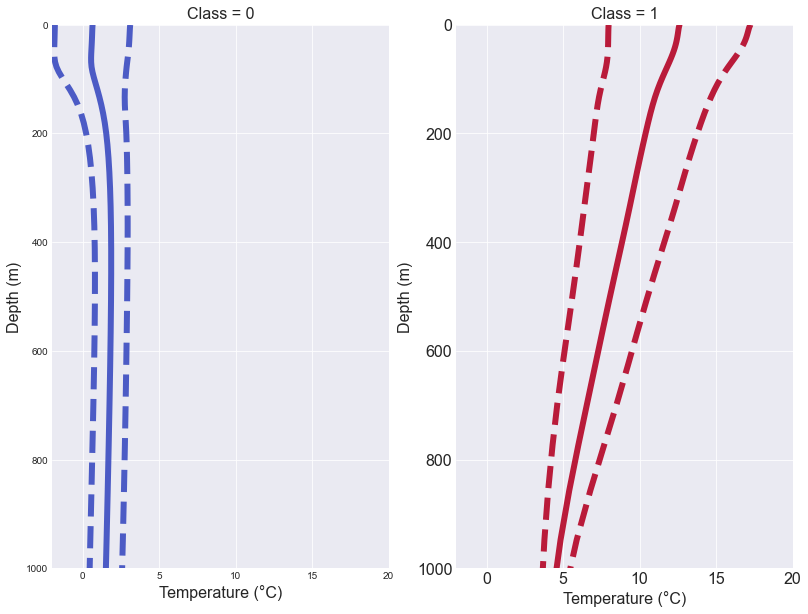

In [127]:
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

<br>

### Plotting location and cluster

In [ ]:
plt.figure(1, figsize=(20,20))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.coastlines()
ax.gridlines()
#im = ax.scatter(sampleDF["lon"], sampleDF["lat"], transform=ccrs.PlateCarree(), c =  sampleDF["labelSorted"], cmap='RdBu_r')
im = ax.scatter(sampleDF["lon"], sampleDF["lat"], transform=ccrs.PlateCarree(), c =  sampleDF[surfaceTempName], cmap='RdBu_r')
cb = plt.colorbar(im)
plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
plt.title("Surface Temperature of Samples")
plt.show()

In [ ]:
locationPlotGroupDFLab(sampleDF, "Location plot of grouping", (25,25), 1)

In [ ]:
locationPlotGroupDFMonthly(sampleDF, "Monthly summaries for training data set", 1)
print("Classifications, grouped by month.")

In [ ]:
locationPlotUncertaintyDFMonthly(sampleDF, "Monthly uncertainty", 1)
print("Uncertainty in classifications, grouped by month.")

Aditional Notes and code

In [ ]:
x = #breakpoint

In [ ]:
date = "2014-09"
i=0

singleMonth = dfESMLatLev.sel(time=date, RunId = i)
singleMonthSurface = singleMonth.sel(lev=singleMonth["lev"].values[0])
singleMonthSurface

In [ ]:
singleMonthScaled = scalerLoad.transform(singleMonth.values)
singleMonthScaledPCA = pca.transform(singleMonthScaled)
labels = bestGMModel.predict(singleMonthScaledPCA) #assignment of class labels from best GMM
posteriorProbs = bestGMModel.predict_proba(singleMonthScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs #2 class I factor

try:
    monthDF = monthDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
monthDF.insert(3, "label", labels, True)
monthDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
monthDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

In [ ]:
singleMonthScaled = scalerLoad.transform(singleMonthStack.T)
singleMonthScaledPCA = pca.transform(singleMonthScaled)
labels = bestGMModel.predict(singleMonthScaledPCA) #assignment of class labels from best GMM
posteriorProbs = bestGMModel.predict_proba(singleMonthScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs #2 class I factor

try:
    monthDF = monthDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
monthDF.insert(3, "label", labels, True)
monthDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
monthDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")